In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed

In [6]:
# Load the dataset
data = pd.read_csv('data/data_imputed_2.csv')

# Drop unnecessary columns
data = data.drop(['temp', 'timestamp_local', 'city_name', 'country_code'], axis=1)

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [8]:
# Define window size for sequence data
window_size = 168

In [9]:
# Prepare data for LSTM
X, y = [], []
for i in range(len(data) - window_size):
    X.append(scaled_data[i:i + window_size])
    y.append(scaled_data[i + window_size])

X, y = np.array(X), np.array(y)

In [10]:
# Split the data into train and test sets
train_size = int(0.8 * len(data))
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [15]:
# Define and compile the LSTM model
model = Sequential([
    Input(shape = (window_size, X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dense(128),
    LSTM(128, return_sequences=False),
    Dense(7)
    # Dense(7)  # 8 output features
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 168, 128)            │          69,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 168, 128)            │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,631 (854.03 KB)

 Trainable params: 218,631 (854.03 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)

Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 88s 214ms/step - loss: 0.0173 - val_loss: 0.0018
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 90s 229ms/step - loss: 0.0061 - val_loss: 0.0012
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 106s 270ms/step - loss: 0.0041 - val_loss: 8.4534e-04
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 97s 244ms/step - loss: 0.0030 - val_loss: 6.4459e-04
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 101s 257ms/step - loss: 0.0026 - val_loss: 5.0064e-04
Epoch 6/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 97s 247ms/step - loss: 0.0021 - val_loss: 4.3736e-04
Epoch 7/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 97s 245ms/step - loss: 0.0018 - val_loss: 3.8210e-04
Epoch 8/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 111s 281ms/step - loss: 0.0015 - val_loss: 3.5044e-04
Epoch 9/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 105s 266ms/step - loss: 0.0013 - val_loss: 3.2679e-04
Epoch 10/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 84s 213ms/step - loss: 0.0012 - val_loss: 3.2199e-04
Epoch 11/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 984s 2s/step - loss: 

In [18]:
import matplotlib.pyplot as plt

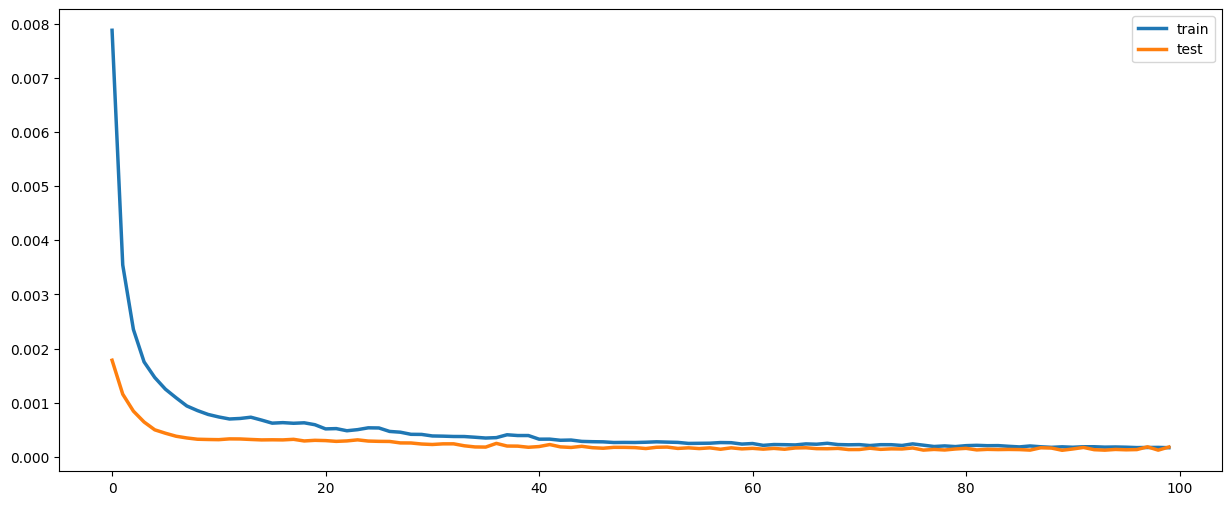

In [19]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [20]:
# Forecasting
predictions = model.predict(X_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step


In [21]:
from sklearn.metrics import mean_squared_error
# Invert scaling for true values
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 7))

# Invert scaling for predicted values
predictions_original = scaler.inverse_transform(predictions.reshape(-1, 7))

# Calculate RMSE after inverting scaling
rmse_original = np.sqrt(mean_squared_error(y_test_original, predictions_original))
print("Root Mean Squared Error (RMSE) after inverting scaling:", rmse_original)

Root Mean Squared Error (RMSE) after inverting scaling: 37.41244484018967


In [22]:
# Extract only the first column (temperature) for true values and predicted values
y_test_aqi = y_test_original[:, 0]
predictions_aqi = predictions_original[:, 0]

# Calculate RMSE for temperature only
rmse_aqi = np.sqrt(mean_squared_error(y_test_aqi, predictions_aqi))
print("Root Mean Squared Error (RMSE) for AQI:", rmse_aqi)

Root Mean Squared Error (RMSE) for AQI: 14.630653598974753


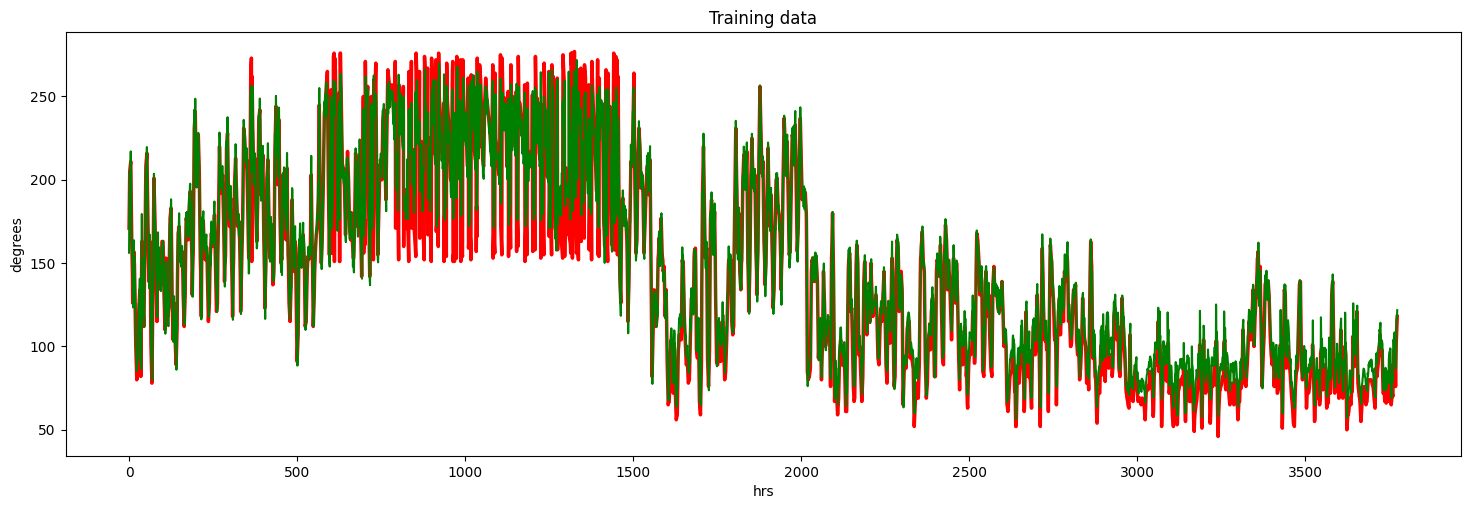

In [23]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_aqi, c = "red", linewidth = 2.5)
plt.plot(predictions_aqi, c = "green")
plt.title("Training data")
plt.show()

In [24]:
# Extract only the first column (temperature) for true values and predicted values
y_test_co = y_test_original[:, 1]
predictions_co = predictions_original[:, 1]

# Calculate RMSE for temperature only
rmse_co = np.sqrt(mean_squared_error(y_test_co, predictions_co))
print("Root Mean Squared Error (RMSE) for CO:", rmse_co)

Root Mean Squared Error (RMSE) for CO: 96.24137860087069


In [25]:
# Number of future time steps to forecast
num_steps = 10  # For example, forecast the next 10 time steps

# Copy the last window_size data points from the test set
future_input = X_test[-1]

# Create an empty list to store future predictions
future_predictions = []

# Forecast future data points
for i in range(num_steps):
    # Reshape the input for prediction
    future_input_reshaped = future_input.reshape((1, window_size, X_test.shape[2]))
    
    # Make prediction
    future_prediction = model.predict(future_input_reshaped)
    
    # Append the prediction to the list of future predictions
    future_predictions.append(future_prediction)
    
    # Update input data for the next prediction
    future_input = np.append(future_input[1:], future_prediction, axis=0)

# Convert the list of future predictions to numpy array
future_predictions = np.array(future_predictions)

# Rescale the future predictions to the original scale
future_predictions_rescaled = scaler.inverse_transform(future_predictions.reshape(-1, 7))

# Print the forecasted future data
print("Forecasted Future Data:")
print(future_predictions_rescaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Forecasted Future Data:
[[121.77022   297.3437     39.135406   41.27415    49.234043   42.357063
   21.773119 ]
 [120.66709   271.2495     36.88043    39.009544   35.21407    34.17154
   14.484825 ]
 [112.377495  262.7016     34.78641    37.792755   21.828287   25.959005
    8.470899 ]
 [103.33772   253.52383    33.731014   38.238285   11.514721   20.044685
    4.636845 ]
 [ 98.47137   219.20602    32.07249    47.561295   15.170785   20.56526
    5.4572825]
 [ 95.67797   212.20401    30.187277   57.760048   20.17323    23.012743
    5.81521  ]
 [ 99.0538    208.45854    28.521616   68.20258    23.682396   25.3963